<a href="https://colab.research.google.com/github/yoouza/bigcontest/blob/master/data_analysis/Various_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling
- **XGBoost 참고**

https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from datetime import datetime, timedelta
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/CARD_SPENDING_RESIDENT.csv', sep='\t')
data_foreigner = pd.read_csv('/content/drive/My Drive/CARD_SPENDING_FOREIGNER.txt', sep='\t', encoding='cp949')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


# Preparing Data
- 서울 중구(140), 서울 노원구(350)
- 카테고리(MCT_CAT_CD)
1. 가구(30), 주방용구(32)
2. 가전(35), 사무통신(52)
3. 레저용품(20)
4. 신변잡화(44)
5. 음료식품(81)
6. 의복(42)

Text(0.5, 1.0, 'JUNGGU AMT')

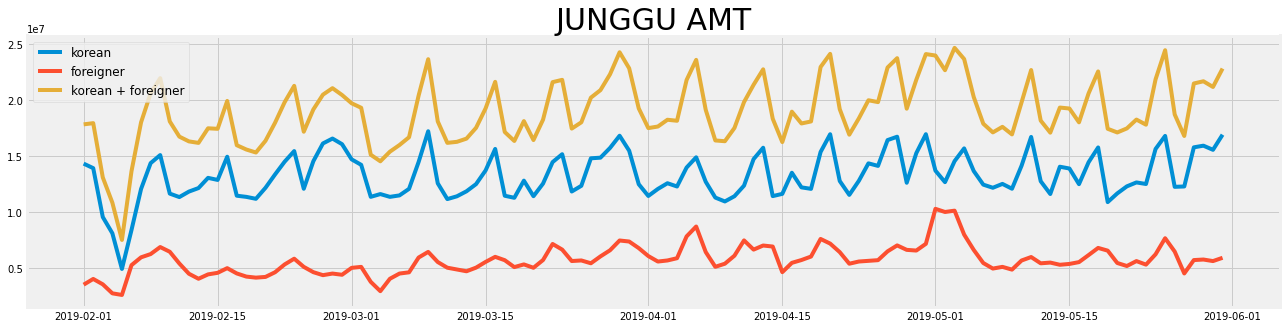

In [48]:
# 2019 중구의 내국인, 외국인 소비량 비교

kor = jung2019.groupby('STD_DD')[['USE_CNT', 'USE_AMT']].sum()
kor_for = jung2019.groupby('STD_DD')[['USE_CNT', 'USE_AMT']].sum() + jung2019_foreigner.groupby('STD_DD')[['USE_CNT', 'USE_AMT']].sum()
fore = jung2019_foreigner.groupby('STD_DD')[['USE_CNT', 'USE_AMT']].sum()
plt.figure(figsize=(20,5))
plt.plot(kor.USE_AMT, label = 'korean')
plt.plot(fore.USE_AMT, label = 'foreigner')
plt.plot(kor_for.USE_AMT, label = 'korean + foreigner')
plt.legend(fontsize = 'large')
plt.title('JUNGGU AMT', size=30)

In [3]:
# 국내
jung = data[data.GU_CD == 140].reset_index().drop('index', axis=1)
jung['STD_DD'] = jung.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
jung2019 = jung[jung.STD_DD < '2020-01-01']
jung2020 = jung[jung.STD_DD > '2020-01-01']

nowon = data[data.GU_CD == 350].reset_index().drop('index', axis=1)
nowon['STD_DD'] = nowon.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
nowon2019 = nowon[nowon.STD_DD < '2020-01-01']
nowon2020 = nowon[nowon.STD_DD > '2020-01-01']

In [4]:
# 외국인
jung_foreigner = data_foreigner[data_foreigner.GU_CD == 140].reset_index().drop('index', axis=1)
jung_foreigner['STD_DD'] = jung_foreigner.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
jung2019_foreigner = jung_foreigner[jung_foreigner.STD_DD < '2020-01-01']
jung2020_foreigner = jung_foreigner[jung_foreigner.STD_DD > '2020-01-01']

nowon_foreigner = data_foreigner[data_foreigner.GU_CD == 350].reset_index().drop('index', axis=1)
nowon_foreigner['STD_DD'] = nowon_foreigner.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
nowon2019_foreigner = nowon_foreigner[nowon_foreigner.STD_DD < '2020-01-01']
nowon2020_foreigner = nowon_foreigner[nowon_foreigner.STD_DD > '2020-01-01']

In [5]:
# 국내 + 외국인 합치기

def indexing(df):
    return df.groupby(['STD_DD', 'MCT_CAT_CD'])[['USE_CNT', 'USE_AMT']].sum()

def sum_korean_foreigner(df_korean, df_foreigner):
    df_foreigner.columns = ['USE_CNT2', 'USE_AMT2']
    df_all = pd.concat([df_korean, df_foreigner], axis=1)
    df_all['USE_CNT_SUM'] = np.nansum([df_all['USE_CNT'], df_all['USE_CNT2']], axis=0)
    df_all['USE_AMT_SUM'] = np.nansum([df_all['USE_AMT'], df_all['USE_AMT2']], axis=0)
    df_all = df_all[['USE_CNT_SUM', 'USE_AMT_SUM']]
    df_all.columns = ['USE_CNT', 'USE_AMT']
    return df_all.reset_index()

jung2019 = indexing(jung2019)
jung2020 = indexing(jung2020)
nowon2019 = indexing(nowon2019)
nowon2020 = indexing(nowon2020)

jung2019_foreigner = indexing(jung2019_foreigner)
jung2020_foreigner = indexing(jung2020_foreigner)
nowon2019_foreigner = indexing(nowon2019_foreigner)
nowon2020_foreigner = indexing(nowon2020_foreigner)

jung2019 = sum_korean_foreigner(jung2019, jung2019_foreigner)
jung2020 = sum_korean_foreigner(jung2020, jung2020_foreigner)
nowon2019 = sum_korean_foreigner(nowon2019, nowon2019_foreigner)
nowon2020 = sum_korean_foreigner(nowon2020, nowon2020_foreigner)

#### 다양한 변수 추가 작업
1. 코로나(전국 or 서울?)
2. 날짜 변수
3. 뉴스

In [171]:
# 코로나
covid = pd.read_csv('/content/drive/My Drive/COVID-19_TimeProvince.csv')
covid_seoul = covid[covid.province == 'Seoul']
covid_seoul = covid_seoul.groupby('date').sum().reset_index()
covid = covid.groupby('date').sum().reset_index()
covid_seoul['date'] = covid_seoul.date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
covid['date'] = covid.date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
covid = covid[covid.date < '2020-06-01'][covid.date >= '2020-02-01']
covid_seoul = covid_seoul[covid_seoul.date < '2020-06-01'][covid_seoul.date >= '2020-02-01']
covid = covid.rename(columns = {'date': 'STD_DD'})
covid_seoul = covid_seoul.rename(columns = {'date': 'STD_DD'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [175]:
jung2019

,STD_DD,MCT_CAT_CD,USE_CNT,USE_AMT
0,2019-02-01,10,6803.0,1336241.0
1,2019-02-01,20,7607.0,709339.0
2,2019-02-01,21,4947.0,147138.0
3,2019-02-01,22,1602.0,44709.0
4,2019-02-01,30,14.0,2554.0
...,...,...,...,...
2699,2019-05-31,70,26612.0,2819772.0
2700,2019-05-31,71,10501.0,1060970.0
2701,2019-05-31,80,369173.0,4914446.0
2702,2019-05-31,81,17715.0,326282.0


In [157]:
covid

,date,time,confirmed,released,deceased
0,2020-01-20,272,1,0,0
1,2020-01-21,272,1,0,0
2,2020-01-22,272,1,0,0
3,2020-01-23,272,1,0,0
4,2020-01-24,272,2,0,0
...,...,...,...,...,...
158,2020-06-26,0,11923,10663,282
159,2020-06-27,0,11963,10805,282
160,2020-06-28,0,12009,10849,282
161,2020-06-29,0,12046,10906,282


In [7]:
# 카테고리 번호로 데이터 뽑아내기
def set_category(df, category_num):
    return df[df.MCT_CAT_CD == category_num].groupby('STD_DD')[['USE_CNT', 'USE_AMT']].sum()

In [16]:
set_category(jung2019, 20)

,USE_CNT,USE_AMT
STD_DD,,
2019-02-01,7607.0,709339.0
2019-02-02,13180.0,1125423.0
2019-02-03,9921.0,865741.0
2019-02-04,9616.0,811836.0
2019-02-05,7182.0,637827.0
...,...,...
2019-05-27,5782.0,503294.0
2019-05-28,8256.0,705820.0
2019-05-29,7957.0,677865.0


# Train / Val / Test split
- Train set: 2 ~ 4월
- Validation set: 5월 1, 2, 3주
- Test set: 5월 마지막 주

In [181]:
# 3주(21일) 동안의 데이터를 바탕으로 다음 일주일 매출을 예측
def preprocessing(df):
    amt_X, amt_y = [], []
    cnt_X, cnt_y = [], []
    for i in range(len(df)-28+1):
        amt_X.append(df.USE_AMT[i:i+21].values)
        cnt_X.append(df.USE_CNT[i:i+21].values)
        amt_y.append(df.USE_AMT[i+21:i+28].values)

    amt_X = np.array(amt_X)
    amt_y = np.array(amt_y)
    cnt_X = np.array(cnt_X)

    X = np.concatenate([amt_X.reshape(-1, 21, 1), cnt_X.reshape(-1, 21, 1)], axis=2)
    y = amt_y
    
    # XGBoost는 3차원을 인식 못하므로 2차원으로 펴주는 과정 필요
    X = X.reshape(len(df)-28+1, -1) 

    return X, y

In [214]:
df = set_category(jung2019, 20)
X, y = preprocessing(df)

df2 = set_category(jung2020, 20)
X2, y2 = preprocessing(df2)

In [215]:
X.shape, y.shape, X2.shape, y2.shape

((93, 42), (93, 7), (94, 42), (94, 7))

In [216]:
X = np.concatenate([X, X2])
y = np.concatenate([y, y2])

In [217]:
X_train, y_train, X_test, y_test = X[:-7], y[:-7], X[-7:], y[-7:]

In [221]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((180, 42), (7, 42), (180, 7), (7, 7))

# 1. XGBoost

In [202]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # Change verbose to True if you want to see it train

[13:06:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [225]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.model_selection import KFold

def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# fitting
multioutputregressor = MultiOutputRegressor(
        xgb.XGBRegressor(objective='reg:squarederror')).fit(X_train, y_train)
# predicting
# np.mean((multioutputregressor.predict(X) - y)**2)

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X_train[train_index], y_train[test_index])
    # lr = LinearRegression(normalize = False)
    # lr.fit(X_train[train_index], y_train[train_index])
    pred = multioutputregressor.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


ValueError: ignored

In [211]:
X_train.shape, X_test.shape

((159, 42), (21, 42))

In [213]:
X[-7:].shape

(7, 42)

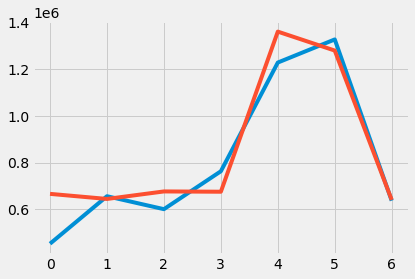

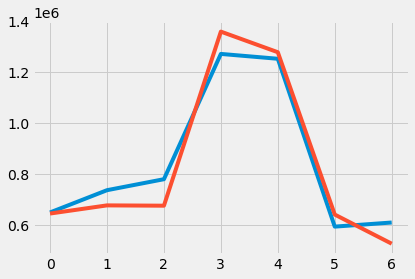

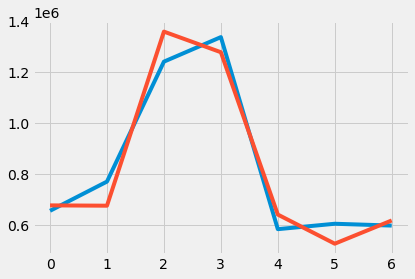

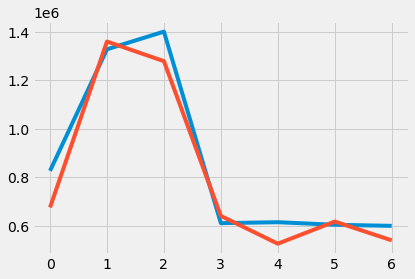

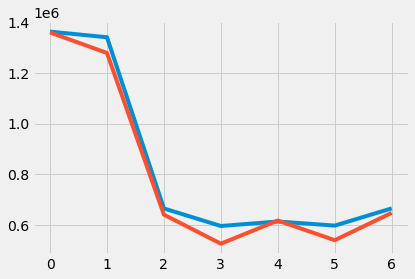

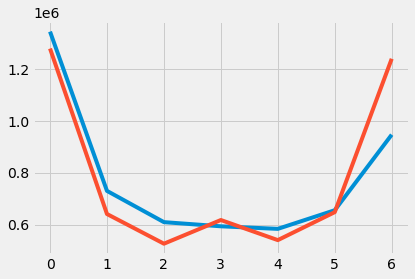

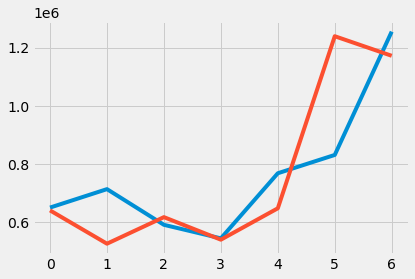

In [208]:
for i in range(7):
    pred = multioutputregressor.predict(X[-7:])[i]
    plt.plot(pred)
    plt.plot(y[-7:][i])
    plt.show()

### Prediction

In [152]:
pred = reg.predict(X[-7:])
pred

array([ 529795.4 ,  641478.44,  593671.4 ,  640457.9 ,  685340.9 ,
       1140098.2 , 1204273.9 ], dtype=float32)

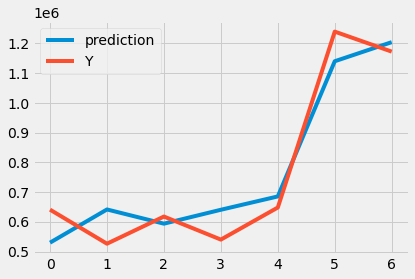

In [153]:
plt.plot(pred, label='prediction')
plt.plot(y[-7:], label='Y')
plt.legend()
plt.show()

In [154]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    print(round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2), '%')

In [155]:
mean_absolute_percentage_error(y[-7:], pred)

35.85 %


### 코로나 확진자 수 Feature 추가

In [138]:
covid = pd.read_csv('/content/drive/My Drive/COVID-19_TimeProvince.csv')
covid_seoul = covid[covid.province == 'Seoul']
covid_seoul = covid_seoul.groupby('date').sum().reset_index()
covid = covid.groupby('date').sum().reset_index()
covid_seoul['date'] = covid_seoul.date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
covid['date'] = covid.date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
covid = covid[covid.date < '2020-06-01'][covid.date >= '2020-02-01']
covid_seoul = covid_seoul[covid_seoul.date < '2020-06-01'][covid_seoul.date >= '2020-02-01']

print('covid')
display(covid.head())
print('covid_seoul')
display(covid_seoul.head())

covid


,date,time,confirmed,released,deceased
0,2020-01-20,272,1,0,0
1,2020-01-21,272,1,0,0
2,2020-01-22,272,1,0,0
3,2020-01-23,272,1,0,0
4,2020-01-24,272,2,0,0


covid_seoul


,date,time,confirmed,released,deceased
0,2020-01-20,16,0,0,0
1,2020-01-21,16,0,0,0
2,2020-01-22,16,0,0,0
3,2020-01-23,16,0,0,0
4,2020-01-24,16,0,0,0


### 전국, 서울 코로나 확진자
- 확진자 수(confirmed)
- 완치(released)
- 사망(deceased)

In [132]:
covid = covid[covid.date < '2020-06-01'][covid.date >= '2020-02-01']
covid_seoul = covid_seoul[covid_seoul.date < '2020-06-01'][covid_seoul.date >= '2020-02-01']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


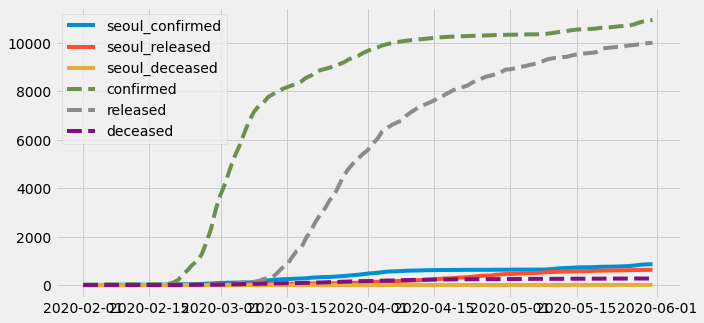

In [133]:
plt.figure(figsize=(10, 5))
plt.plot(covid_seoul.date, covid_seoul.confirmed, label='seoul_confirmed')
plt.plot(covid_seoul.date, covid_seoul.released, label='seoul_released')
plt.plot(covid_seoul.date, covid_seoul.deceased, label='seoul_deceased')
plt.plot(covid.date, covid.confirmed, label='confirmed', ls="--")
plt.plot(covid.date, covid.released, label='released', ls="--")
plt.plot(covid.date, covid.deceased, label='deceased', ls="--")
plt.legend()
plt.show()

In [142]:
covid

,date,time,confirmed,released,deceased
0,2020-01-20,272,1,0,0
1,2020-01-21,272,1,0,0
2,2020-01-22,272,1,0,0
3,2020-01-23,272,1,0,0
4,2020-01-24,272,2,0,0
...,...,...,...,...,...
158,2020-06-26,0,11923,10663,282
159,2020-06-27,0,11963,10805,282
160,2020-06-28,0,12009,10849,282
161,2020-06-29,0,12046,10906,282


In [141]:
df

,USE_CNT,USE_AMT
STD_DD,,
2019-02-01,7607.0,709339.0
2019-02-02,13180.0,1125423.0
2019-02-03,9921.0,865741.0
2019-02-04,9616.0,811836.0
2019-02-05,7182.0,637827.0
...,...,...
2019-05-27,5782.0,503294.0
2019-05-28,8256.0,705820.0
2019-05-29,7957.0,677865.0


In [ ]:
# 전국 covid features 추가
df = df2020.groupby('STD_DD')[['USE_CNT', 'USE_AMT']].sum()
df['date'] = df.index
df = pd.merge(covid, df.reset_index()).groupby('STD_DD').sum().drop('time', axis=1)

split_date = '2020-05-03'
split_date2 = '2020-05-25'

df_train = df[df.index <= split_date]
df_ = df[df.index > split_date] # test + val
df_val = df_[df_.index <= split_date2]
df_test = df_[df_.index > split_date2]

X_train_, y_train = create_features(df_train, label='USE_AMT')
X_test_, y_test = create_features(df_val, label='USE_AMT')
X_train = X_train_.join(df_train[['USE_CNT', 'confirmed', 'released', 'deceased']])
X_test = X_test_.join(df_val[['USE_CNT', 'confirmed', 'released', 'deceased']]) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row